# 📋(Optional)Homework6. Detecting and Mitigiating AI Bias

**Due Date:---**

---

## What is this?

This jupyter notebook outlines the overall process of the assignment, which includes (1) *skeleton codes that you will need to complete* and (2) *the motivation scenario along with codes*. The objective of `Homework #6` is to figure out that the model's prediction is biased with respect to nationality of reviews, and to mitigate such bias.

In this assignment, students are required to implement the following **✅two functions** and answer for **❓four questions**. We are going to provide a specific algorithm for you to implement so that the task is not open-ended but concrete enough. Specific precondition and postcondition of the functions are going to be explained later.

\

* `getBiasScore` :

* `undersampling` :

Also, the dataset and overall process of this assignment has been borrowed from a set of references and tuned to present more evident results on educational purpose. Although we are dealing with the real data and existing techniques, results in this assignment do not represent the real world: we cannot directly generalize our observations in this assignment. Please focus on methodological aspects of dealing with bias. You may want to discuss limitations of the overall process of this assignment as well.

\

### References

\[1\] [Kaggle: 515K Hotel Reviews Data in Europe
](https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe)

\[2\] [PyData Amsterdam 2018 - Selection bias: The elephant in the room](https://www.youtube.com/watch?v=3ZWCKr0vDtc)

---

### 👍Acknowledgment

This assignment was greatly inspired by [**KAIST CS492: Human-AI Interaction**](https://hai.kixlab.org/assignments), taught by Prof. Juho Kim. We would like to extend our sincere gratitude to [Ph.D. student Hyungyu Shin](https://hyungyu.com/) (TA) and [Prof. Juho Kim](https://juhokim.com/) for their invaluable insights and for serving as a key source for this work.

---

### 🔥Getting Started

> 1. Go to **File > Save a copy in Drive** to save a copy of the assignment to your Google Drive. Make sure to work on your own copy, as changes made to the original template will not be saved. You must complete the assignment in the copy saved to your Google Drive.  

> 2. Run the cell directly below to download the dataset (dataset path: `content/drive/MyDrive/COSE432/HW6/dataset`).  

<!-- > 3. If you're curious about the modularized code, you can refer to the code under the `COSE432/HW6` directory. -->

In [ ]:
import os
# Check if the COSE432 folder exists, and if it doesn't, run git clone
if not os.path.exists('/content/COSE432'):
    !git clone https://github.com/ku-dxplab/COSE432.git
else:
    print("The COSE432 folder already exists. Skipping git clone.")
!pwd
!ls

# If you want to download the latest version,
# delete the existing COSE432 folder from your Google Drive and try running this cell again.

Cloning into 'COSE432'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 41 (delta 2), reused 37 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 13.86 MiB | 10.55 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content
COSE432  drive	sample_data


---
### 📋 Basic Guide for HW4 Notebook

- As you proceed through the assignment, make sure to execute all cells in the notebook (shortcut: `Ctrl + Enter` OR `Cmd + Enter`).

- The sections marked `❓Discussion {num}` require you to write your reflections based on the results of the previous cells.
- The sections marked ✅ indicate where you need to implement your code.

- After completing the code for all the ❓ or ✅ marked cells, ensure the notebook runs without errors through to the final cell.

- Once you've implemented the code in all the ✅ cells, confirm that all cells have been executed. Finally, go to **File > Download** and save the notebook as `HW4-JohnSmith-2020345678.ipynb`.

---

### 🥲 FAQ
If you have any questions about the assignment, feel free to [contact the TA](https://ku-dxplab.github.io/staff/#teaching-assistant).

---

**Now, let's start! 🚀**

# 0. Introduction
The objective of this project is to perform sentiment analysis (only positive and negative) on an imbalanced hotel review dataset.

To accomplish the objective, we are going to follow the procedure below.

    1. EDA / Prepare the dataset
        
    2. Train a model             
    
    3. Evaluate the model
    
    4. Check whether the model is biased with respect to dialects
    
    5. Investigate why such bias happens
    
    6. Mitigate the bias


In [ ]:
# @title Imports and Setup {"display-mode":"form"}
# @markdown This cell imports all necessary libraries and modules for data processing, visualization, and machine learning tasks. It includes tools for:

# @markdown - **Data manipulation** (`numpy`, `pandas`)

# @markdown - **Visualization** (`matplotlib`, `seaborn`, `plotly`)

# @markdown - **Text processing and feature extraction** (`nltk`, `TfidfVectorizer`, `CountVectorizer`)

# @markdown - **Modeling and evaluation** (`sklearn`, `tensorflow`, `xgboost`)

# @markdown It also downloads the English stopwords using `nltk`, which will be useful for text processing, and sets up plot aesthetics for consistent visualization.

# @markdown If you're curious about what each part does, feel free to look through the code. Otherwise, just run this cell as is (shortcut: `Ctrl + Enter` OR `Cmd + Enter`).


from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

from numpy import newaxis
from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import xgboost as xgb
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Activation, GRU, BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

plt.rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In the cell below, we load the training dataset, `reviewTrain.csv`, which contains hotel reviews. This data will be used to train a model that classifies text reviews as positive or negative. Our primary focus is on the `Negative_Review` and `Positive_Review` columns, each representing different sentiments expressed by users for the same hotel. Other columns will not be used in the training stage. If you're interested, you can view the original dataset [here](https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe).

In [ ]:
# @title Import Data
df_hotel_reviews = pd.read_csv('/content/COSE432/HW6/dataset/train/reviewTrain.csv')
df_hotel_reviews.head()

,Reviewer_Nationality,Reviewer_Score,Trip_Type,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,days_since_review
0,Switzerland,2.9,Business,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,4/14/2017,7.7,Hotel Arena,Hotel is going through a major construction r...,110,1403,Love the design of the renovated product The ...,15,4,111 day
1,United Kingdom,5.0,Business,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,10/12/2016,7.7,Hotel Arena,In a terrible state with builders everywhere ...,42,1403,Good location Cheap,5,1,295 day
2,United Kingdom,4.6,Business,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,9/12/2016,7.7,Hotel Arena,Hotel is having some construction work done t...,56,1403,Location was ok and has access to all the pub...,28,5,325 day
3,United States of America,3.8,Business,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/26/2016,7.7,Hotel Arena,No Limited A C in common areas Dangerous meta...,52,1403,Good water pressure in shower,6,1,373 day
4,China,3.1,Business,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,12/22/2015,7.7,Hotel Arena,the restaurant food was terrible my first roo...,85,1403,nothing,2,9,590 day


# 1. Data Preparation

### Exploratory Data Analysis (EDA)

This cell conducts exploratory data analysis (EDA) to help visualize and understand the structure and patterns in the review dataset. You can skip this part if you’d like, as it’s not essential to run or fully understand each line at this stage. However, expanding this cell will allow you to:

- View the overall column structure and descriptive statistics of the dataset
- Explore the distribution of `Reviewer_Score` as well as the sentiment (positive vs. negative) expressed in reviews

The observations here give context to the data’s sentiment distribution, helping us see patterns such as word count differences between positive and negative reviews.

In [ ]:
df_hotel_reviews.columns.tolist()

['Reviewer_Nationality',
 'Reviewer_Score',
 'Trip_Type',
 'Hotel_Address',
 'Additional_Number_of_Scoring',
 'Review_Date',
 'Average_Score',
 'Hotel_Name',
 'Negative_Review',
 'Review_Total_Negative_Word_Counts',
 'Total_Number_of_Reviews',
 'Positive_Review',
 'Review_Total_Positive_Word_Counts',
 'Total_Number_of_Reviews_Reviewer_Has_Given',
 'days_since_review']

In [ ]:
df_hotel_reviews.describe(include='object')

,Reviewer_Nationality,Trip_Type,Hotel_Address,Review_Date,Hotel_Name,Negative_Review,Positive_Review,days_since_review
count,71737,71737,71737,71737,71737,71737,71737,71737
unique,201,2,1472,731,1471,47697,61003,731
top,United Kingdom,Business,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,No Negative,No Positive,1 days
freq,27287,60889,1007,344,1007,18274,3275,344


In [ ]:
df_hotel_reviews.Reviewer_Score.describe()

,Reviewer_Score
count,71737.000000
mean,8.093857
std,1.963298
min,2.500000
25%,7.500000
50%,8.800000
75%,9.600000
max,10.000000


**Review Score**

In [ ]:
fig = px.histogram(df_hotel_reviews, x="Reviewer_Score", title='Review Score Distribution', nbins=20, text_auto=True)
fig.show()

**Review Sentiment Distribution**

In [ ]:
print(f"Total Positive word count {df_hotel_reviews.Review_Total_Positive_Word_Counts.sum()}, Total negative word count {df_hotel_reviews.Review_Total_Negative_Word_Counts.sum()}")

Total Positive word count 1115583, Total negative word count 1290236


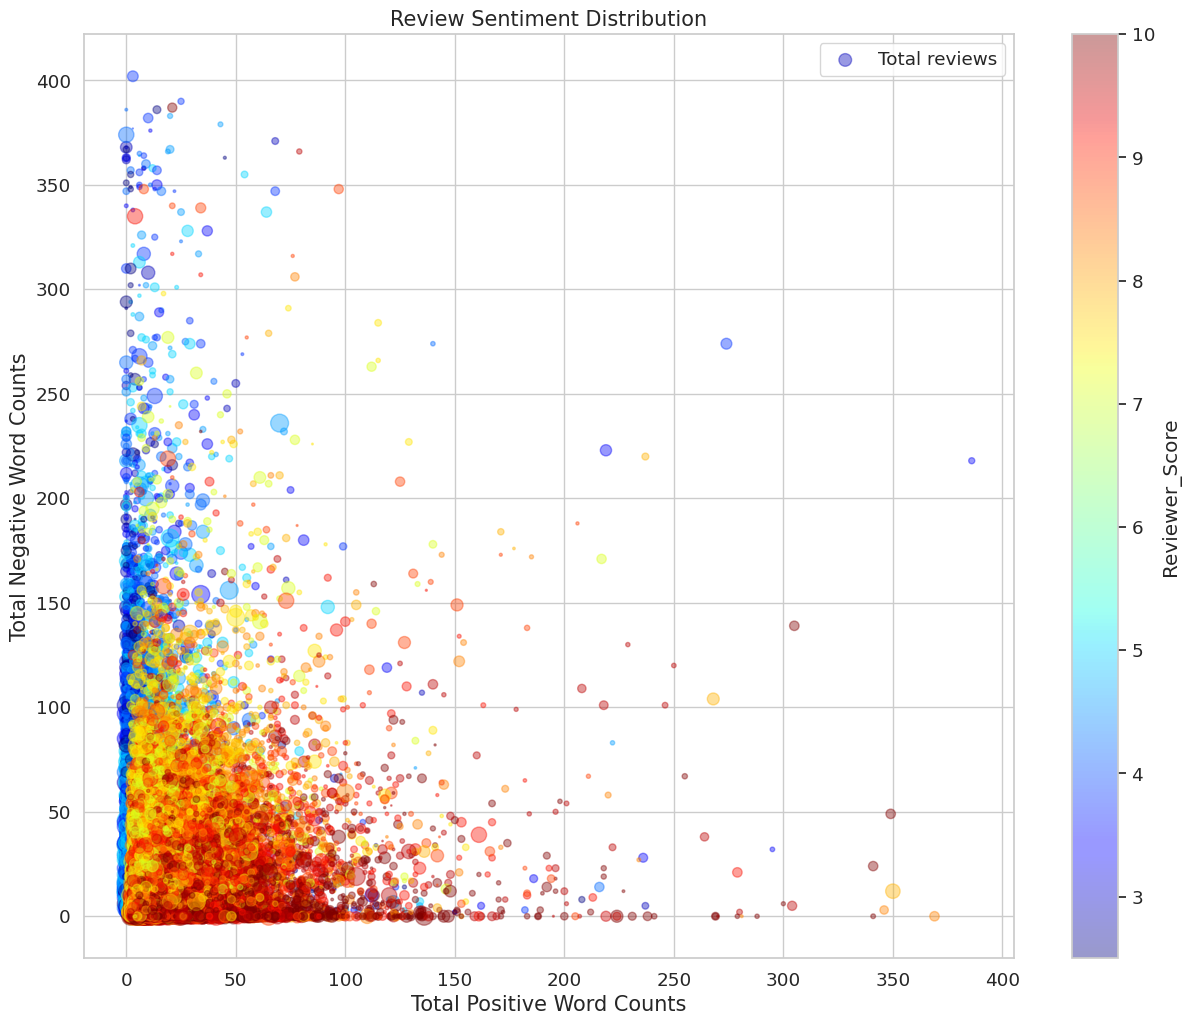

In [ ]:
df_hotel_reviews.plot(kind='scatter',
                      x='Review_Total_Positive_Word_Counts',
                      y='Review_Total_Negative_Word_Counts',
                      label='Total reviews',
             s=df_hotel_reviews.Total_Number_of_Reviews/100,
             c='Reviewer_Score',
             cmap=plt.get_cmap('jet'),
             colorbar=True,
             alpha=0.4, figsize=(15,12),
             sharex=False,
             )
font_size = 15
plt.title("Review Sentiment Distribution",  fontsize=font_size)
plt.xlabel("Total Positive Word Counts", fontsize=font_size)
plt.ylabel("Total Negative Word Counts",  fontsize=font_size)
plt.legend()
plt.show()

**❗ Observation Point**

From the above graph, we can infer that :

* The value of **Total positive word counts** is lower than **total negative word counts**
* Although the distribution of **Positive Review** seems to dominate negative reviews, the distribution of **Negative Review** has higher negative word count in general

**Positive Vs Negative Word Count Among Hotel Reviews**

In [ ]:
px.histogram(x=abs(df_hotel_reviews.Review_Total_Positive_Word_Counts - df_hotel_reviews.Review_Total_Negative_Word_Counts), title='Difference Between Total Positive and Negative Word Count Among Hotel Reviews')

### **Cleaning Review Text**

> There are some values like `No Positive` in positive review and `No Negative` in negative review which can be counted ass opposite sentiment, hence replacing those phrases

> After that, we will merge texts from both positive and negative review columns to make them into a single text feature

In [ ]:
# outliers
df_hotel_reviews['Negative_Review'][1]

' In a terrible state with builders everywhere We had to wait to get into our room as the conference event builders were blocking the door Our room that we were told was new was in a poor state of repair '

In [ ]:
df_hotel_reviews.loc[:, 'Positive_Review'] = df_hotel_reviews.Positive_Review.apply(lambda x: x.replace('No Positive', ''))
df_hotel_reviews.loc[:, 'Negative_Review'] = df_hotel_reviews.Negative_Review.apply(lambda x: x.replace('No Negative', ''))

In [ ]:
df_hotel_reviews['review'] = df_hotel_reviews.Positive_Review + df_hotel_reviews.Negative_Review

**Set Sentiment Type**
> Setting the sentiment threshold to **6**, everything is negative below **6**

In [ ]:
df_hotel_reviews["review_type"] = df_hotel_reviews["Reviewer_Score"].apply(
    lambda x: "bad" if x < 6 else "good")

In [ ]:
df_reviews = df_hotel_reviews[["review", "review_type"]]

**Review Type Distribution**

In [ ]:
# df_reviews.review_type.hist();

fig = px.histogram(df_reviews, x="review_type", title='Review Type Distribution', text_auto=True)
fig.show()

# imbalanced distribution

In [ ]:
# Texts labeled as Good (1)
df_reviews[df_reviews.review_type == 'good'].review.value_counts()

,count
review,
Location,64
Everything Nothing,55
Great location,28
Everything,25
Everything,19
...,...
I didn t eat at the hotel No evening meal but a couple of good restaurants very close Hotel was simple but comfortable and clean Very friendly and helpful reception staff Room was a little small,1
Breakfast was good but expensive at 24 The room was very quiet but small The bed was very comfortable Access to metro and all of Paris was easy Very attentive staff,1
Although I wanted an early check in and was confirmed the request when I arrived was told that I had to wait for a while because the rooms were not ready However when I extended my stay the staff were so helpful with my requests that I forgot about early check in ordeal I would like to especially thank Maria and Osiel for the incredible customer they provided during my stay The location is superb and the hotel is kept very well I would be back if I ever needed to be in that area The breakfast is not as varied as I had anticipated It is sufficient but I did expect more variety,1


In [ ]:
# Texts labeled as Bad
df_reviews[df_reviews.review_type == 'bad'].review.value_counts()

,count
review,
Nothing Everything,26
nothing everything,8
Staff,7
Nothing Every thing,6
Nothing Nothing,6
...,...
Hotel is close to the tube station this is its only good point I never usually bother to write reviews however I had such a bad experience I have decided to make an exception This hotel if it can be called that is responsible for without doubt the worst nights sleep that I have ever had having spent 12 years in the army i m not exactly a princess about where I sleep either The bed was terrible sleeping on the pavement outside would of been more comfortable I have never felt a bed so hard My back still hurts now an its two days later The shower was also terrible with only luke warm water Breakfast is served from 0730 which is no good when you have to be somewhere early When it is being served its horrendous hardly any selection Stale tasteless croissants served with bitter coffee Also the reception is not manned between 2300 0730hrs so if you do need anything you can t get it anyway I would never stay here again I have no idea how this place has had good reviews Poor poor standards,1
An accumulation of small things made my experience quite poor got burnt twice due to unreliable shower temperature minibar removed sink out of order and super noisy environment Won t come back,1
Got bitten all over by bed Bugs,1


In [ ]:
good_reviews = df_reviews[df_reviews.review_type == 'good']
bad_reviews = df_reviews[df_reviews.review_type == 'bad']

### Word Cloud

In [ ]:
good_reviews_text = " ".join(good_reviews.review.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.review.to_numpy().tolist())

In [ ]:
# generate Word Cloud
def gen_wc(txt):
    stopwords = set(STOPWORDS)
    wc = WordCloud(width=800, height=400,background_color="white", max_font_size=300, stopwords = stopwords).generate(txt)
    plt.figure(figsize=(14,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

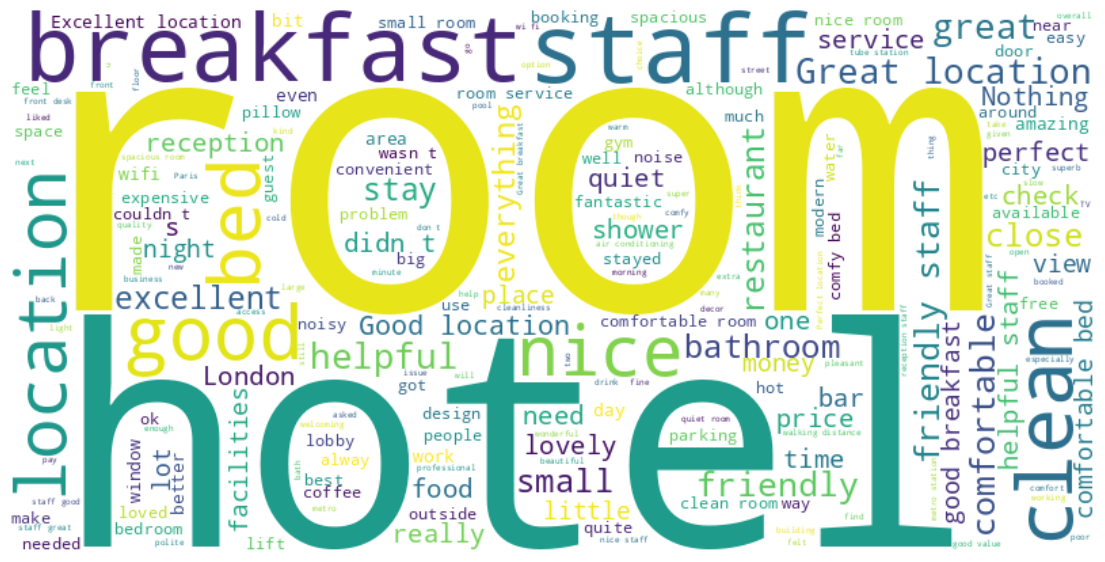

In [ ]:
# Good Reviews
gen_wc(good_reviews_text)

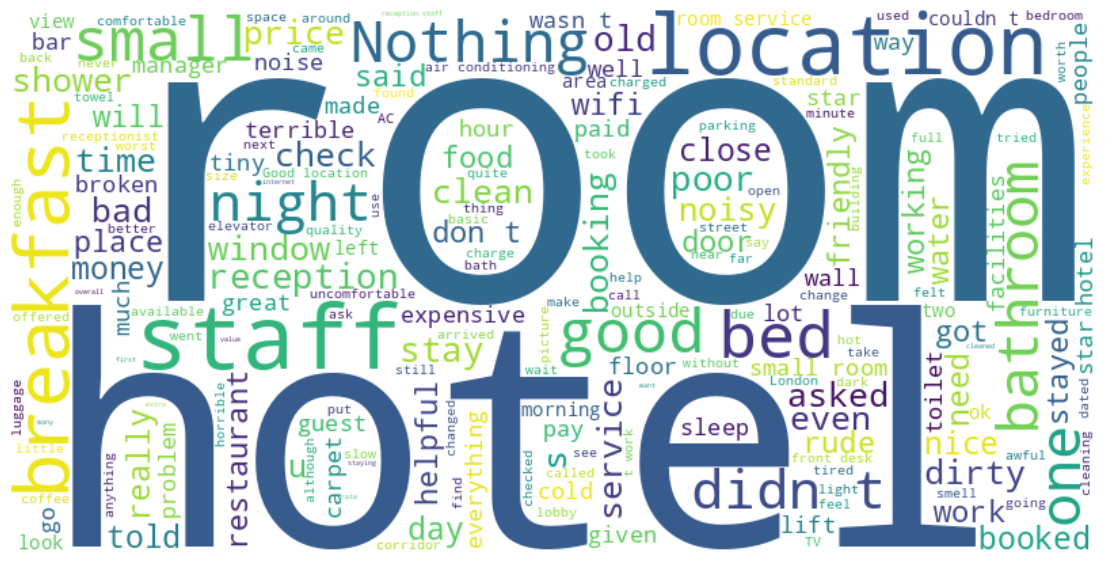

In [ ]:
# Bad Reviews
gen_wc(bad_reviews_text)

### Resample Dataset

Under sample the positive review to achieve a balanced distribution between reviews.

In [ ]:
good_df = good_reviews.sample(n=len(bad_reviews), random_state=RANDOM_SEED)

df_review_resampled = pd.concat([good_df, bad_reviews]).reset_index(drop=True)
df_review_resampled.shape

(23378, 2)

In [ ]:
df_review_resampled.head()

,review,review_type
0,decoration small room for twin room,good
1,No No,good
2,Perfect location,good
3,The facilities are very nice Close to the off...,good
4,Good location and the staff were pleasant wel...,good


**After Resampled**

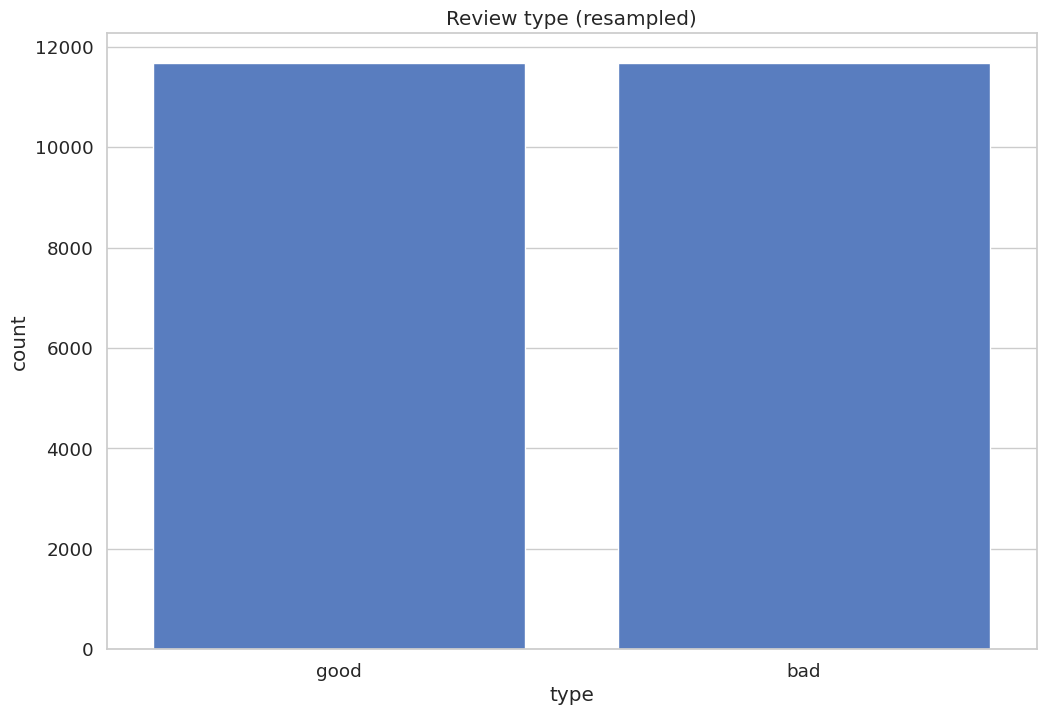

In [ ]:
sns.countplot(
  x='review_type',
  data=df_review_resampled,
  order=df_review_resampled.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)");

# 3. Modeling

## Data Preparation
`🚀 Run these hidden cells!`

The dataset needs preprocessing to train our model. For this assignment, we will use a Logistic Regression model, which requires vectorizing text data into numerical values. This process involves converting review text into a feature set that can be processed by the Logistic Regression model. Specifically, we will use [TF-IDF](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) with [n-grams](https://en.wikipedia.org/wiki/N-gram) (1 ≤ n ≤ 3) to create feature vectors for each review.

**Encoding Labels**:  
   The `LabelEncoder` is used to encode review sentiment labels (`review_type`) as binary values. Here, `0` represents negative reviews, and `1` represents positive reviews.

In [ ]:
label_enc = preprocessing.LabelEncoder()
encoded_review = label_enc.fit_transform(df_review_resampled.review_type.values)

In [ ]:
print(f"Encoded classes: {label_enc.classes_}")
print(f"Encoded class as 0: {label_enc.classes_[0]}")
print(f"Encoded class as 1: {label_enc.classes_[1]}")

Encoded classes: ['bad' 'good']
Encoded class as 0: bad
Encoded class as 1: good


**Train/Test Split**:  
   The dataset is split into training and validation sets, where 25% of the data is reserved for validation. Although this split is called "test" in our code, it is used only to validate performance during training and should not be confused with actual test data used for inference.

In [ ]:
train_reviews, test_reviews, y_train, y_test = train_test_split(
    df_review_resampled.review,
    encoded_review,
    test_size=0.25,
    random_state=RANDOM_SEED
  )

**Feature Engineering with TF-IDF**:  
   We apply TF-IDF vectorization to transform each review into a vector of numerical values. This representation allows our Logistic Regression model to process text data as input.


In [ ]:
%%time
tfv = TfidfVectorizer(min_df=3,  max_features=None,
            strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True,
            stop_words='english')

tfv.fit(list(train_reviews) + list(test_reviews))

X_train_tfv = tfv.transform(train_reviews)
X_test_tfv = tfv.transform(test_reviews)

CPU times: user 3.45 s, sys: 103 ms, total: 3.55 s
Wall time: 3.56 s


## Logistic Regression Training and Evaluation

Here, we train a Logistic Regression model using the TF-IDF feature vectors generated from the review data. We first split the TF-IDF matrix into training (`X_train_tfv`, `y_train`) and validation (`X_test_tfv`, `y_test`) sets to evaluate performance during training. During this phase, we simply fit the model without any advanced hyperparameter tuning like cross-validation.

The `model_predict` function:
- Fits the Logistic Regression model on the training set
- Predicts sentiment probabilities on the validation set
- Calculates metrics such as log-loss and [ROC AUC](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.roc_auc_score.html) to measure initial model performance


In [ ]:
def model_predict(clf, X_train,y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    predictions = clf.predict_proba(X_test)

    print (f"logloss: {metrics.log_loss(y_test, predictions):0.3f}")
    print (f"ROC AUC: {metrics.roc_auc_score(y_test, predictions[:, 1]):0.3f}")

    return {
        'model': clf,
        'X_test': X_test,
        'y_test': y_test,
		    'y_prob': predictions
    }

In [ ]:
%%time
clf = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000)

modelResult = model_predict(clf, X_train_tfv,y_train, X_test_tfv, y_test)

logloss: 0.339
ROC AUC: 0.943
CPU times: user 959 ms, sys: 510 ms, total: 1.47 s
Wall time: 785 ms


In [ ]:
# @title ## Model Evaluation on Validation Data

# @markdown We evaluate the trained Logistic Regression model on the validation set to examine initial model performance. Using `evaluateModel`, we:

# @markdown - Generate a classification report detailing precision, recall, and F1-score

# @markdown - Visualize a confusion matrix to analyze the model’s accuracy in predicting positive and negative sentiments

# @markdown **Note**: This validation performance might look promising. However, it only reflects the training/validation data (called "test" in this code) and does not guarantee generalization to new data. The actual inference performance will be explored in the next step.

import seaborn
from sklearn.metrics import classification_report

def evaluateModel(p, names) :
    model = p['model']
    X_test = p['X_test']
    y_test = p['y_test']

    y_preds = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    report = classification_report( y_test, y_preds )

    print(report)


    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test,y_preds)
    matrix_proportions = np.zeros((len(names),len(names)))
    for i in range(0,len(names)):
        matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
    confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
    plt.figure(figsize=(5,5))
    seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
    plt.ylabel(r'True categories',fontsize=14)
    plt.xlabel(r'Predicted categories',fontsize=14)
    plt.tick_params(labelsize=12)

    #Uncomment line below if you want to save the output
    #plt.savefig('confusion.pdf')

    return {
        'report': report,
        'y_preds': y_preds,
		    'y_prob': y_prob
    }

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2914
           1       0.88      0.85      0.86      2931

    accuracy                           0.87      5845
   macro avg       0.87      0.87      0.87      5845
weighted avg       0.87      0.87      0.87      5845



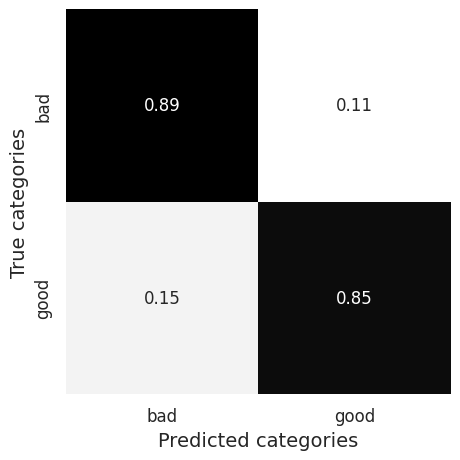

In [ ]:
predictionResult = evaluateModel(modelResult, label_enc.classes_)

**❗Note. Common Model Evaluation Metrics**

- **Precision**: The percentage of correct positive predictions among all predictions made as positive. Precision answers the question: *Of all the instances the model predicted as positive, how many were actually positive?*

- **Recall**: The percentage of correct positive predictions among all actual positive instances. Recall answers the question: *Of all the actual positive instances, how many did the model correctly identify?*

- **F1-Score**: The harmonic mean of precision and recall. It provides a single measure of the model’s accuracy in handling imbalanced data, balancing both precision and recall.

# 4. Inference

Now we're going to use the trained model to classify a totally new hotel review dataset, `reviewTest.csv`, which has been conditionally sampled from the original hotel reviews to demonstrate the effects of **selection bias**. Unlike `reviewTrain.csv`, which was randomly sampled, this test dataset preserves certain characteristics of the original data, allowing us to examine how biases can emerge in a real-world application. The result shows the model performance (precision, recall, f1-score) and the confusion matrix.

In [ ]:
df_hotel_reviews_test = pd.read_csv('/content/COSE432/HW6/dataset/test/reviewTest.csv')
df_hotel_reviews_test.head()

,Review,Reviewer_Nationality,Reviewer_Score,Class,Satisfied,Trip_Type
0,The staff here are indifferent and the hotel ...,Australia,4.2,0,0,Business
1,The hotel operators are cheats liars and thie...,United States of America,2.5,0,0,Business
2,I didnt like the way a staff member handled m...,Philippines,5.0,0,0,Business
3,Restaurant is dual purpose Good menu in the e...,United Kingdom,3.3,0,0,Business
4,The staff were all friendly However I was sho...,Kuwait,5.0,0,0,Family


In [ ]:
df_hotel_reviews_test_inf = df_hotel_reviews_test[['Review', 'Class']].rename(columns={'Review': 'review', 'Class': 'review_type'})
df_hotel_reviews_test_inf['review_type'] = df_hotel_reviews_test_inf['review_type'].map({1: 'good', 0: 'bad'})
df_hotel_reviews_test_inf

,review,review_type
0,The staff here are indifferent and the hotel ...,bad
1,The hotel operators are cheats liars and thie...,bad
2,I didnt like the way a staff member handled m...,bad
3,Restaurant is dual purpose Good menu in the e...,bad
4,The staff were all friendly However I was sho...,bad
...,...,...
1995,Having just come from a five star hotel I was...,good
1996,Friendly receptionist on arrival Good size ro...,good
1997,Big room,good
1998,Clean modern comfortable roomy lovely roomy s...,good


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_inference_data(model, vectorizer, label_encoder, inference_df, output_plot = True, output_dict = False):

    # Encode the labels in inference data
    inference_df['encoded_review_type'] = label_encoder.transform(inference_df['review_type'])

    # Transform the review text using TF-IDF vectorizer
    X_inference_tfv = vectorizer.transform(inference_df['review'])

    # Predict using the trained model
    y_inference_preds = model.predict(X_inference_tfv)
    y_inference_probs = model.predict_proba(X_inference_tfv)

    # Evaluate the results
    inference_report = classification_report(inference_df['encoded_review_type'], y_inference_preds, output_dict=output_dict)

    # Confusion Matrix
    conf_matrix = confusion_matrix(inference_df['encoded_review_type'], y_inference_preds)
    conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix
    class_names = label_encoder.classes_

    if output_plot:

      print("Classification Report for Inference Data:")
      print(inference_report)

      # Plot Confusion Matrix
      plt.figure(figsize=(5, 5))
      sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
      plt.xlabel("Predicted Label")
      plt.ylabel("True Label")
      plt.title("Normalized Confusion Matrix for Inference Data")
      plt.show()

    # Return evaluation results in a dictionary
    results = {
        'classification_report': inference_report,
        'confusion_matrix': conf_matrix,
        'predicted_labels': y_inference_preds,
        'predicted_probabilities': y_inference_probs
    }

    return results

Classification Report for Inference Data:
              precision    recall  f1-score   support

           0       0.48      0.94      0.64       258
           1       0.99      0.85      0.92      1742

    accuracy                           0.86      2000
   macro avg       0.74      0.90      0.78      2000
weighted avg       0.92      0.86      0.88      2000



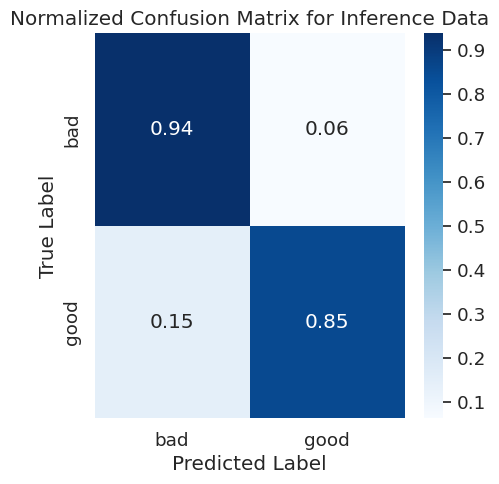

In [ ]:
inference_results = evaluate_inference_data(modelResult['model'], tfv, label_enc, df_hotel_reviews_test_inf)

Classification Report for Inference Data:
              precision    recall  f1-score   support

           0       0.48      0.94      0.64       258
           1       0.99      0.85      0.92      1742

    accuracy                           0.86      2000
   macro avg       0.74      0.90      0.78      2000
weighted avg       0.92      0.86      0.88      2000



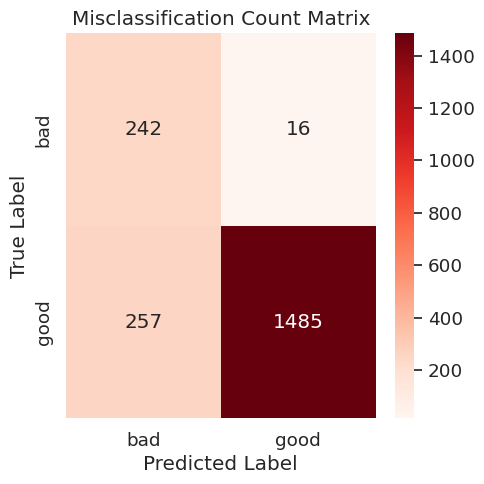

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_inference_data_with_visualizations(model, vectorizer, label_encoder, inference_df):

    # Encode the labels in inference data
    inference_df['encoded_review_type'] = label_encoder.transform(inference_df['review_type'])

    # Transform the review text using TF-IDF vectorizer
    X_inference_tfv = vectorizer.transform(inference_df['review'])

    # Predict using the trained model
    y_inference_preds = model.predict(X_inference_tfv)
    y_inference_probs = model.predict_proba(X_inference_tfv)

    # Evaluate the results
    inference_report = classification_report(inference_df['encoded_review_type'], y_inference_preds)
    print("Classification Report for Inference Data:")
    print(inference_report)

    # Confusion Matrix (Normalized)
    conf_matrix = confusion_matrix(inference_df['encoded_review_type'], y_inference_preds)
    conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix
    class_names = label_encoder.classes_

    # Plot Normalized Confusion Matrix
    # plt.figure(figsize=(5, 5))
    # sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    # plt.xlabel("Predicted Label")
    # plt.ylabel("True Label")
    # plt.title("Normalized Confusion Matrix for Inference Data")
    # plt.show()

    # Plot Misclassification Matrix with Raw Counts
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Misclassification Count Matrix")
    plt.show()

    # Plot Precision-Recall Curve for Each Class
    # plt.figure(figsize=(7, 5))
    # for i, class_name in enumerate(class_names):
    #     precision, recall, _ = precision_recall_curve(inference_df['encoded_review_type'] == i, y_inference_probs[:, i])
    #     plt.plot(recall, precision, label=f"Class {class_name} (0=bad, 1=good)")
    # plt.xlabel("Recall")
    # plt.ylabel("Precision")
    # plt.title("Precision-Recall Curve for Each Class")
    # plt.legend(loc="lower left")
    # plt.show()

    # Return evaluation results in a dictionary
    results = {
        'classification_report': inference_report,
        'confusion_matrix': conf_matrix,
        'predicted_labels': y_inference_preds,
        'predicted_probabilities': y_inference_probs
    }

    return results

# Example usage
inference_results = evaluate_inference_data_with_visualizations(modelResult['model'], tfv, label_enc, df_hotel_reviews_test_inf)


## ❓ Writing Question 1

**(10pt)** After executing the EDA/Modeling/Inference code on the Hotel Review dataset, analyze and discuss your observations. *Do you think the training has been appropriately processed? Provide your reasoning based on the plot result above.* We highly encourage you to attach specific examples and what observations you made about them.  
   
.  
.  

---

Please refer to [HW4 description on ku-dxplab.github.io](https://ku-dxplab.github.io/assignments) and write your answer in a separate document (not in this notebook). You are free to include any photos or screenshots as attachments.

# 5. Check whether the model is biased

In this step, we aim to understand:
- If our model’s predictions differ across review types (`Family` vs. `Business`)
- How selection bias in the dataset can lead to unexpected prediction distributions, even when the training data was balanced in terms of positive and negative classes

By analyzing this separate test data, we illustrate that balancing class distributions alone does not prevent biases related to other features (e.g., `Trip_Type`) from affecting the model.

Now we have a trained model, which can be used for analyzing hotel reviews. Let's check whether the model is biased with respect to the trip types, Family and Business. Here, the meaning of "our model is biased" means that __our model prediction gives different distributions across the trip types (needs comment from you: do you think this is reasonable?)__. For example, if our model tends to predict a large portion of Family trip reviews as negative, whereas a large portion of Business trip reviews as positive, then we can say our model is biased (assuming the data collection method between Family and Business trip reviews does not have any inherent bias).

Now we're going to use the trained model to classify a totally new hotel review dataset. The data contains a label that represents the trip type (Family or Business). Note that we do not have the ground truth labels for the sentiment of the reviews, because we do not actually know the real sentiment of a review we are going to apply our model to. Therefore, we cannot measure model performance (i.e., precision, recall, F1-score) with this new dataset, but we can only check for bias.

In [ ]:
df_hotel_reviews_test['Trip_Type'].value_counts()

,count
Trip_Type,
Business,1171
Family,829


### ✅ (Task 1) Measure the score of bias (25pt)

Given the column `tripType` (that represents whether the trip is categorized as Family or Business) and the column `class` (that represents the sentiment of the review as either 'good' or 'bad'), we can measure whether the sentiment predictions show bias between different types of trips. There can be multiple ways to compute such bias, and each measure might capture different perspectives on the bias.

One simple measure of bias is to compare the ratio of predicted sentiments across the different trip types. In other words, we can compute how much percentage each predicted sentiment label accounts for between Family trips and Business trips, and then compare the values.

For example, let's say our model predicted **1000** Family trip reviews, and **282** of them were classified as `'bad'`. In this case, the `'bad'` label accounts for **28.2%** of the Family trip reviews ($ P(t = \text{bad} | \text{Family}) = 0.282 $). Similarly, let's compute the same value for Business trips. Let's say we have **1000** Business trip reviews, and **217** of them were classified as `'bad'` ($ P(t = \text{bad} | \text{Business}) = 0.217 $ ).

In this scenario, we can observe that the model tends to predict Family trip reviews as `'bad'` more often compared to Business trip reviews, with a ratio of:

$$
\frac{P(t = \text{bad} | \text{Family})}{P(t = \text{bad} | \text{Business})} = 1.299
$$

This means that the model is approximately **29.9%** more likely to predict Family reviews as `'bad'` compared to Business reviews.

Similarly, for `'good'` sentiment, if the model predicted **547** Family reviews as `'good'` and **954** Business reviews as `'good'`, the ratio would be:

$$
\frac{P(t = \text{good} | \text{Family})}{P(t = \text{good} | \text{Business})} = 0.573
$$

This indicates that the model is **less likely to predict Family reviews as 'good'** compared to Business reviews—specifically, the likelihood is approximately **57.3%** compared to Business reviews.

Your task is to implement the following function `getBiasScore(predictionResultTable)` that computes the ratio between the portion of a sentiment label in Family and that of Business, i.e.:

$$
\frac{ P(t=c_i|Family) }{P(t=c_i|Business)}
$$

where $ t $ refers to reviews and $ c_i $ refers to a label representing the sentiment (`good` or `bad`). Using this approach, we can get a value for each label and understand if there is a bias in the sentiment predictions across different trip types.

In [ ]:
def getBiasScore(predictionResultTable):
    # returns values that represent the bias for each label (good/bad sentiment)

    # Create the bias score DataFrame
    returnValue = pd.DataFrame( ######################
                                #       TODO         #
                                ######################
                               , columns=['label', 'p_Family', 'p_Business', 'ratio'])

    return returnValue

  label  p_Family  p_Business     ratio
0   bad       282         217  1.299539
1  good       547         954  0.573375


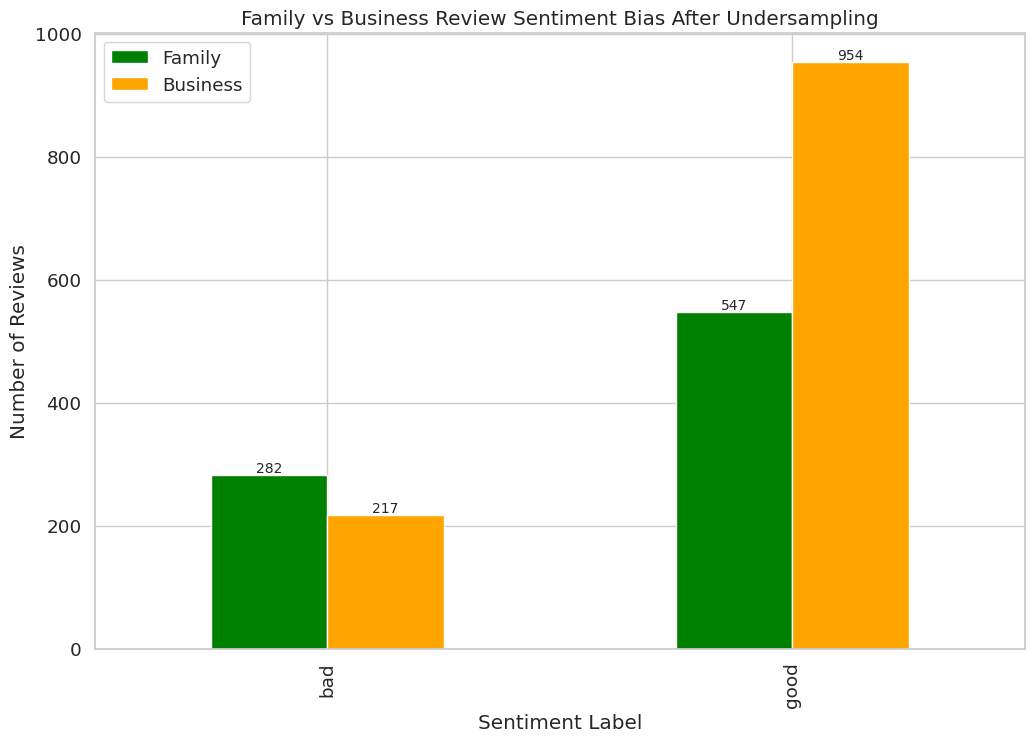

In [ ]:
# We create datasetInfo to hold labels
labels = ['bad', 'good']
datasetInfo = {'label': labels}

# Replace predictionResultTable with the df_hotel_reviews_test to include predicted labels
# Here we assume `inference_results['predicted_labels']` contains the model predictions
# Add the predicted labels to the test dataframe for evaluation purposes
df_hotel_reviews_test['predLabel'] = inference_results['predicted_labels']

# Create a bias score dataframe
biasScore = getBiasScore(df_hotel_reviews_test)

print(biasScore)

# Plotting the bar graph to visually compare Family and Business review sentiments
Family_statistics = df_hotel_reviews_test.loc[df_hotel_reviews_test['Trip_Type'] == 'Family']['predLabel'].value_counts()
Business_statistics = df_hotel_reviews_test.loc[df_hotel_reviews_test['Trip_Type'] == 'Business']['predLabel'].value_counts()

df_plot = pd.DataFrame([[datasetInfo['label'][x], biasScore['p_Family'][x], biasScore['p_Business'][x]] for x in range(len(datasetInfo['label']))],
                       columns=['label', 'Family', 'Business'])

# df_plot.plot(kind='bar', x='label', color=['green', 'orange'], width=0.5, position=0.5)
# plt.xlabel("Sentiment Label")
# plt.ylabel("Number of Reviews")
# plt.title("Family vs Business Review Sentiment Bias")
# plt.show()
ax = df_plot.plot(kind='bar', x='label', color=['green', 'orange'], width=0.5, position=0.5)

# Add text labels on top of each bar
for p in ax.patches:
    ax.annotate(str(int(p.get_height())),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Label the axes and the plot
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Reviews")
plt.title("Family vs Business Review Sentiment Bias After Undersampling")
plt.show()


You can observe that our trained model predicts Family trip reviews as negative more often than Business trip reviews, but it also overpredicts Business reviews as positive. Then our next questions are:

- Why does our model have such bias even though our training data doesn't explicitly include any information on trip types?
- How can we mitigate such bias?

We are going to answer these questions.



# 6. Investigate why such bias happens

In this section, we will explore how the class distribution of sampled test data impacts model performance, specifically precision, and why this might occur.

To start, note that the `reviewTest` dataset is a subset of data sampled from the original booking.com dataset, ensuring no overlap with the reviewTrain dataset. This test data preserves the class imbalance present in the original dataset, meaning there are more Positive (Class 1) samples than Negative (Class 0) samples. This imbalance can have a noticeable impact on model evaluation metrics, especially precision.

The following code allows us to observe how changing the number of Class 1 (Positive) samples in the test data impacts precision, particularly for Class 0:

In [ ]:
df_hotel_reviews_test_org = pd.read_csv('/content/COSE432/HW6/dataset/test/reviewTest.csv')
df_hotel_reviews_test_org['Class'].value_counts()

,count
Class,
1,1742
0,258


We sample n instances from the Class 1 data using label_1_data.sample(n=n, random_state=42).

By combining this sampled Class 1 data with the entirety of Class 0 data, we create a new test dataset with varying proportions of Class 1.


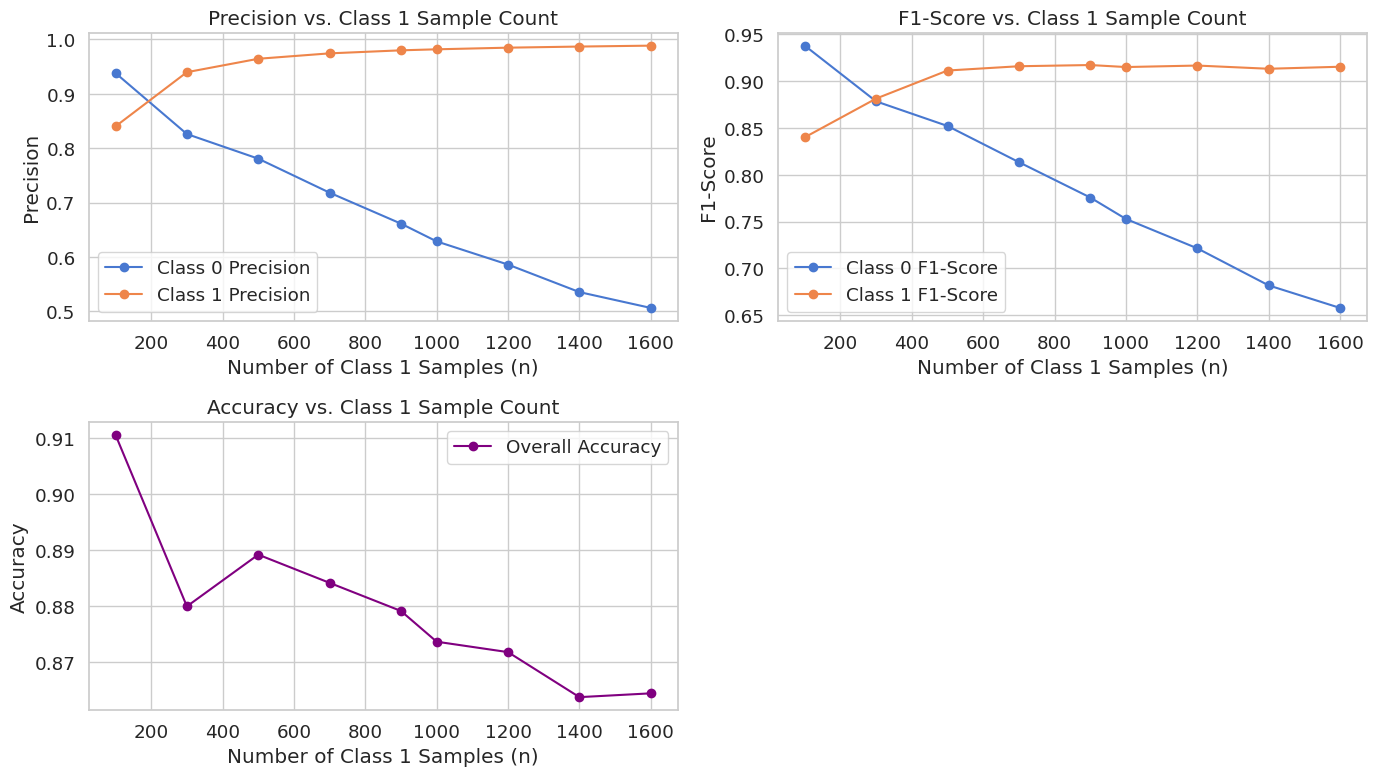

In [ ]:
n_values = [100, 300, 500, 700, 900, 1000, 1200, 1400, 1600]
precision_0_list, precision_1_list = [], []
f1_score_0_list, f1_score_1_list = [], []
accuracy_list = []

for n in n_values:
    df_hotel_reviews_test = df_hotel_reviews_test_org.copy()
    label_1_data = df_hotel_reviews_test[df_hotel_reviews_test['Class'] == 1]
    label_0_data = df_hotel_reviews_test[df_hotel_reviews_test['Class'] == 0]

    label_1_sampled = label_1_data.sample(n=n, random_state=42)
    df_hotel_reviews_test = pd.concat([label_1_sampled, label_0_data]).reset_index(drop=True)

    df_hotel_reviews_test_inf = df_hotel_reviews_test[['Review', 'Class']].rename(columns={'Review': 'review', 'Class': 'review_type'})
    df_hotel_reviews_test_inf['review_type'] = df_hotel_reviews_test_inf['review_type'].map({1: 'good', 0: 'bad'})

    results = evaluate_inference_data(modelResult['model'], tfv, label_enc, df_hotel_reviews_test_inf, output_plot=False, output_dict=True)
    report = results['classification_report']
    #print(report)

    precision_0_list.append(report['0']['precision'])
    precision_1_list.append(report['1']['precision'])
    f1_score_0_list.append(report['0']['f1-score'])
    f1_score_1_list.append(report['1']['f1-score'])
    accuracy_list.append(report['accuracy'])

plt.figure(figsize=(14, 8))

# Precision Plot
plt.subplot(2, 2, 1)
plt.plot(n_values, precision_0_list, label='Class 0 Precision', marker='o')
plt.plot(n_values, precision_1_list, label='Class 1 Precision', marker='o')
plt.xlabel('Number of Class 1 Samples (n)')
plt.ylabel('Precision')
plt.title('Precision vs. Class 1 Sample Count')
plt.legend()

# F1-Score Plot
plt.subplot(2, 2, 2)
plt.plot(n_values, f1_score_0_list, label='Class 0 F1-Score', marker='o')
plt.plot(n_values, f1_score_1_list, label='Class 1 F1-Score', marker='o')
plt.xlabel('Number of Class 1 Samples (n)')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Class 1 Sample Count')
plt.legend()

# Accuracy Plot
plt.subplot(2, 2, 3)
plt.plot(n_values, accuracy_list, label='Overall Accuracy', marker='o', color='purple')
plt.xlabel('Number of Class 1 Samples (n)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Class 1 Sample Count')
plt.legend()

plt.tight_layout()
plt.show()


**❗Observation Points**

- **Impact on Precision**:
   - By varying the number of Class 1 samples, we observe that **Class 0 precision fluctuates significantly** while other metrics remain relatively stable.
   - This indicates that the model has a **tendency to over-predict Class 1 (Positive)**. When Class 1 data becomes more dominant, the model increasingly misclassifies Class 1 as Class 0, which lowers the precision for Class 0.

- **The Role of Selection Bias**:
   - This behavior reveals that the model’s training may have been biased towards Class 1, either due to class imbalance or insufficient representation of Class 0 characteristics (e.g., Family Trip Negative reviews). This bias impacts the model’s ability to accurately distinguish Class 0, thus affecting the precision.

- **NOTE**. Although this task aims to provide insights into Performance Blindness, observing changes in precision for Class 0 alone does not directly confirm Performance Blindness. Performance Blindness refers to a phenomenon where the observed performance on the test data appears higher than the actual performance in real-world scenarios. To verify this, a more extensive evaluation across diverse real-world data would be necessary.


1. Load and Decompose the Original Dataset

In [ ]:
df_hotel_reviews = pd.read_csv('/content/COSE432/HW6/dataset/train/reviewTrain.csv')

df_hotel_reviews["Class"] = df_hotel_reviews["Reviewer_Score"].apply(
    lambda x: 0 if x < 6 else 1)

df_family = df_hotel_reviews[df_hotel_reviews['Trip_Type'] == 'Family']
df_business = df_hotel_reviews[df_hotel_reviews['Trip_Type'] == 'Business']

2. Analyze Sentiment Distribution for Each Group

In [ ]:
# Analyze the sentiment distribution for each group
family_dist = df_family['Class'].value_counts()
business_dist = df_business['Class'].value_counts()

# Create a dataframe to store the distribution results
df_dist = pd.DataFrame({
    'label': ['bad', 'good'],
    'Family': [family_dist.get(0, 0), family_dist.get(1, 0)],
    'Business': [business_dist.get(0, 0), business_dist.get(1, 0)]
})

3. Plot the Sentiment Distribution

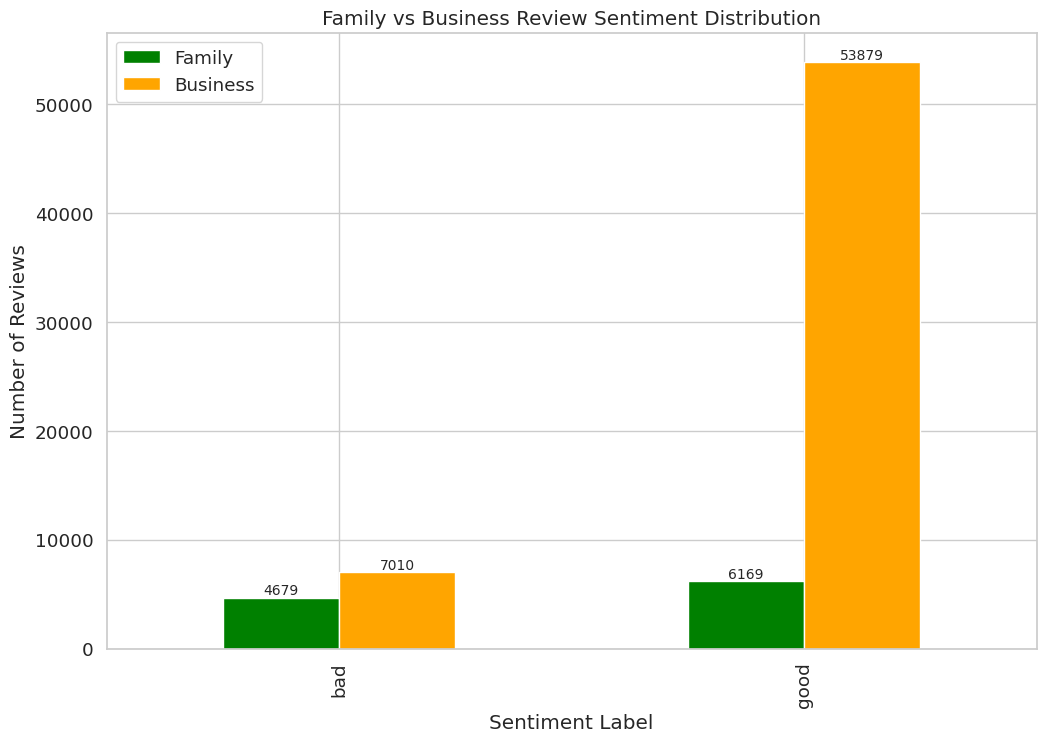

In [ ]:
ax = df_dist.plot(kind='bar', x='label', color=['green', 'orange'], width=0.5, position=0.5)

# Add text labels on top of each bar
for p in ax.patches:
    ax.annotate(str(int(p.get_height())),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Label the axes and the plot
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Reviews")
plt.title("Family vs Business Review Sentiment Distribution")
plt.show()

4. Calculate Review Ratios

In [ ]:
# Print out the total number of reviews in each group
print("Total number of Family reviews: {}".format(len(df_family)))
print("Total number of Business reviews: {}".format(len(df_business)))

# Calculate the ratio between the number of reviews in Family and Business groups
ratio = len(df_family) / len(df_business)
print("The ratio between the number of Family and Business reviews: {:.2f}".format(ratio))

Total number of Family reviews: 10848
Total number of Business reviews: 60889
The ratio between the number of Family and Business reviews: 0.18


The above graph shows that (1) the distribution of reviews in the training data is highly skewed, with Business reviews having a significantly higher proportion of 'good' labels compared to Family reviews, and (2) the number of Business reviews (60,889) is approximately 5.6x greater than that of Family reviews (10,848). This imbalance motivates us to consider **undersampling** Business reviews with 'good' labels or oversampling Family reviews to address this bias. We may also explore adjusting the balance between 'good' and 'bad' labels within the Family group to mitigate the model’s biased behavior.

# 7. Mitigate the bias

With such observation, we are going to mitigate the bias (i.e. we are going to reduce the bias score that we have computed by `getBiasScore`.

### ✅ (Task 2) Undersampling (25pt)

Now you need to implement a bias mitigation technique yourself. In this assignment, we use `Undersampling`. We will follow the exact same pipeline as in Steps 1 through 5, which include data preparation, model training, evaluation, and inference. Undersampling will be applied during the data preparation stage, before model training. Complete the `undersampleData()` function in the first cell below.


In [ ]:
def undersampleData(trainingData, ratio):

    ######################
    #        TODO        #
    ######################

    return undersampled_data

Execute the pipeline from Steps 1 through 5 to observe the effect. If you have correctly implemented `undersampleData()`, the resulting plot in the cell below should match the previous one.

After undersampling, number of Business 'good' reviews:  23174
Classification Report After Undersampling:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      2886
           1       0.88      0.94      0.91      5620

    accuracy                           0.87      8506
   macro avg       0.87      0.84      0.85      8506
weighted avg       0.87      0.87      0.87      8506



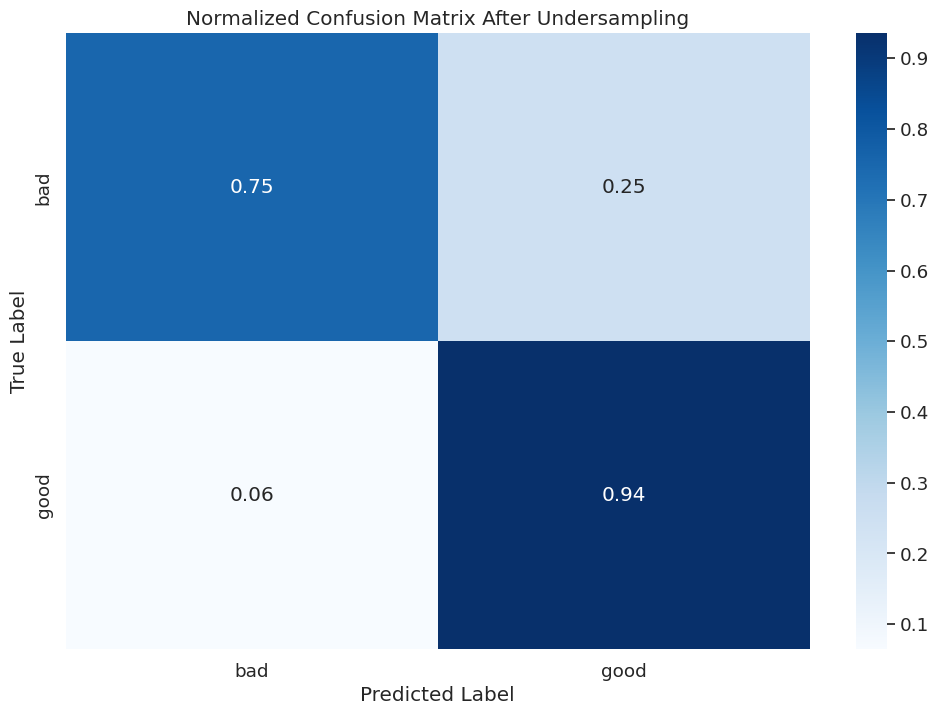

In [ ]:
# Load the dataset
df_hotel_reviews = pd.read_csv('/content/COSE432/HW6/dataset/train/reviewTrain.csv')

# Data Cleaning and Preparation (same as before)
df_hotel_reviews.loc[:, 'Positive_Review'] = df_hotel_reviews.Positive_Review.apply(lambda x: x.replace('No Positive', ''))
df_hotel_reviews.loc[:, 'Negative_Review'] = df_hotel_reviews.Negative_Review.apply(lambda x: x.replace('No Negative', ''))

df_hotel_reviews['review'] = df_hotel_reviews.Positive_Review + df_hotel_reviews.Negative_Review

# Apply undersampling
df_undersampled = undersampleData(df_hotel_reviews, ratio=0.3)
print("After undersampling, number of Business 'good' reviews: ", len(df_undersampled[df_undersampled['Trip_Type'] == 'Business']))

# Re-prepare the final preprocessed data
df_undersampled["review_type"] = df_undersampled["Reviewer_Score"].apply(
    lambda x: "bad" if x < 6 else "good")
df_reviews_resampled = df_undersampled[["review", "review_type"]]

# Encoding Labels after undersampling
label_enc = preprocessing.LabelEncoder()
encoded_review_resampled = label_enc.fit_transform(df_reviews_resampled.review_type.values)

# Train/Test Split (using undersampled data)
train_reviews_resampled, test_reviews_resampled, y_train_resampled, y_test_resampled = train_test_split(
    df_reviews_resampled.review,
    encoded_review_resampled,
    test_size=0.25,
    random_state=42
)

# Feature Engineering: TF-IDF
tfv = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True, stop_words='english')

tfv.fit(list(train_reviews_resampled) + list(test_reviews_resampled))

X_train_tfv_resampled = tfv.transform(train_reviews_resampled)
X_test_tfv_resampled = tfv.transform(test_reviews_resampled)

# Train the Model
clf = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000)
clf.fit(X_train_tfv_resampled, y_train_resampled)

# Evaluation
y_preds_resampled = clf.predict(X_test_tfv_resampled)
inference_report_resampled = classification_report(y_test_resampled, y_preds_resampled)

print("Classification Report After Undersampling:")
print(inference_report_resampled)

# Plot Confusion Matrix
conf_matrix_resampled = confusion_matrix(y_test_resampled, y_preds_resampled)
conf_matrix_norm_resampled = conf_matrix_resampled / conf_matrix_resampled.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix_norm_resampled, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix After Undersampling")
plt.show()

Now, let's compute the bias score again.

Bias Score After Undersampling:
  label  p_Family  p_Business     ratio
0   bad       128         158  0.810127
1  good       701        1013  0.692004


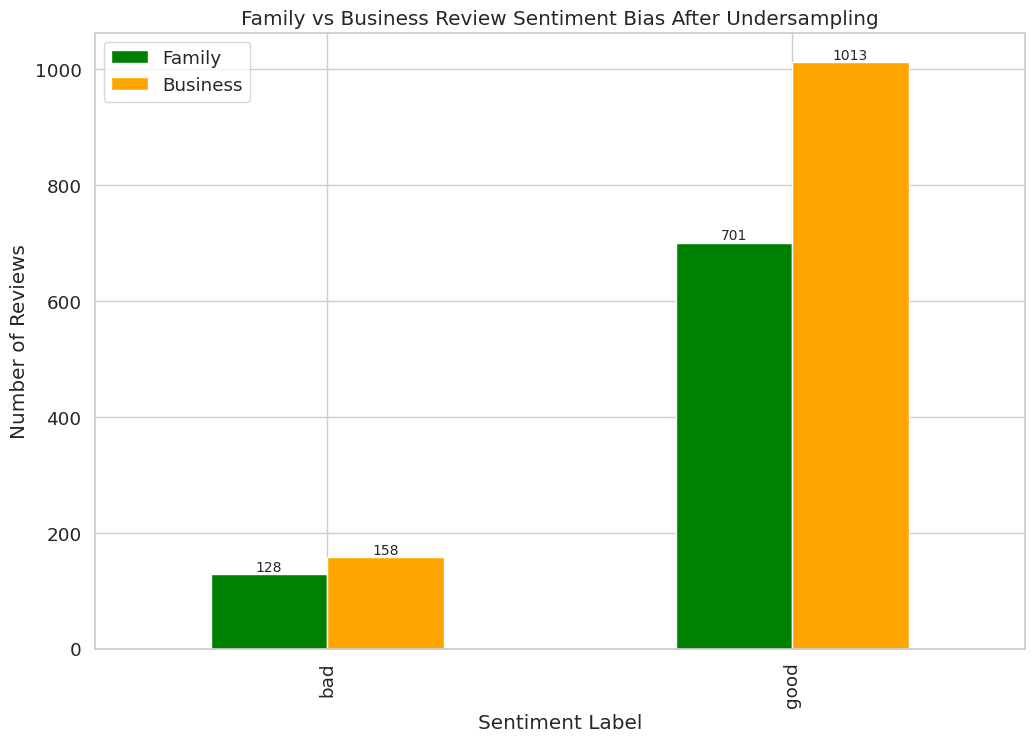

In [ ]:
# Assuming `getBiasScore()` is defined as before
df_hotel_reviews_test = pd.read_csv('/content/COSE432/HW6/dataset/test/reviewTest.csv')
df_hotel_reviews_test['predLabel'] = clf.predict(tfv.transform(df_hotel_reviews_test['Review']))

# Calculate Bias Score after Undersampling
biasScore_after_undersampling = getBiasScore(df_hotel_reviews_test)
print("Bias Score After Undersampling:")
print(biasScore_after_undersampling)

# Plot Bias Comparison
# df_plot = pd.DataFrame([[datasetInfo['label'][x], biasScore_after_undersampling['p_Family'][x], biasScore_after_undersampling['p_Business'][x]] for x in range(len(datasetInfo['label']))],
#                        columns=['label', 'Family', 'Business'])

# df_plot.plot(kind='bar', x='label', color=['green', 'orange'], width=0.5, position=0.5)
# plt.xlabel("Sentiment Label")
# plt.ylabel("Number of Reviews")
# plt.title("Family vs Business Review Sentiment Bias After Undersampling")
# plt.show()
# Plot Bias Comparison
df_plot = pd.DataFrame([[datasetInfo['label'][x], biasScore_after_undersampling['p_Family'][x], biasScore_after_undersampling['p_Business'][x]] for x in range(len(datasetInfo['label']))],
                       columns=['label', 'Family', 'Business'])

# Create the plot
ax = df_plot.plot(kind='bar', x='label', color=['green', 'orange'], width=0.5, position=0.5)

# Add text labels on top of each bar
for p in ax.patches:
    ax.annotate(str(int(p.get_height())),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Label the axes and the plot
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Reviews")
plt.title("Family vs Business Review Sentiment Bias After Undersampling")
plt.show()


**❗Observation Points**
- The bias in predicting Family reviews as 'bad' decreased from 1.244 to 0.810 after undersampling, showing more balanced predictions for 'bad' sentiment between Family and Business reviews.
- The bias score for 'good' predictions improved from 0.570 to 0.692, but Family reviews are still less likely to be labeled as 'good' compared to Business.
- Overall, undersampling has improved balance in predictions, but further fine-tuning or different sampling strategies may help reduce remaining bias, especially in 'good' predictions for Family reviews.

## ❓ Writing Question 2.
(10pt) Have you observed anything on the relationship between the model performance and bias measure, even if it is not significant in our assignment? If so, share your opinions on why such a relationship could exist.

## ❓ Writing Question 3

(10pt) We explored one debiasing techniques in pre-processing. Consider whether there are other debiasing techniques that could be applied using the same training dataset. ***Are there additional debiasing methods beyond the two covered in this assignment?***  If so, identify and describe them; if not, explain why.  

## ❓ Writing Question 4

**(20pt)** Debiasing methods can be applied not only during pre-processing and post-processing but also within the model training phase. While integrating debiasing techniques into the training process can be challenging due to resource constraints or project limitations, it is feasible and can yield benefits sometimes (e.g., see [Zhang et al., "Mitigating Unwanted Biases with Adversarial Learning," 2018]).  

  
Imagine you are using a Large Language Model (LLM) API in your application, and you notice that the model exhibits a specific type of bias—for instance, it generates gender-stereotypical responses when asked about certain professions or provides culturally biased answers in specific contexts.  
  

***Given that you cannot modify the underlying model directly, discuss how you might interact with the LLM to mitigate this bias from a Human-AI Interaction and Interface perspective.* *Propose at least one method to overcome the bias interactively without altering the model itself.*** Consider strategies such as prompt engineering, designing user interfaces that promote fairness, or implementing feedback mechanisms. Explain how your proposed method addresses the identified bias and enhances the overall user experience. Support your discussion with specific scenarios or examples.  

---

Please refer to [HW4 description on ku-dxplab.github.io](https://ku-dxplab.github.io/assignments) and write your answer in a separate document (not in this notebook). You are free to include any photos or screenshots as attachments.

# 📑 Submission to KULMS


---
- Once you've implemented the code in all the ✅ cells, confirm that all cells have been executed. Finally, go to **File > Download > Download .ipynb** and save the notebook as `HW4-JohnSmith-2020345678.ipynb`.

- **NOTE.** Make sure to submit the notebook with all cells already run. All cells in your Jupyter Notebook must be executed before submission 🚨


---
Your assignment submissions **MUST BE** done on **KULMS** with your writing report.

- Summit to KULMS:

  - A **zip** file with your name and ID : `HW4-JohnSmith-2020345678.zip` (as direct `.ipynb` submissions may not be possible on KULMS🤮).

- Your submission should be structured as follows:
```
📂 HW4-JohnSmith-2020345678.zip
│
├── HW4-JohnSmith-2020345678.pdf       # Your Discussion Report (~ 2 pages)
└── HW4-JohnSmith-2020345678.ipynb     # Your completed implementation
```



# 📋 References
